# Hourly clustering over whole year 2024

In [13]:
import polars as pl
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import re

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation
from cluster_statistics import plot_cluster_percentiles

## Data extraction and preprocessing

In [2]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")
output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")
output_folder.mkdir(parents=True, exist_ok=True)

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess(df):
    # Parse the timestamp column (assuming 'timestamp' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    # Group by time_of_day across all days in the range and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    
    return day_avg

def normalize(df):  
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

for file_path in file_paths:
    df = pl.read_csv(file_path)
    time_avg = day_avg_preprocess(df)
    time_avg_norm = normalize(time_avg)
    
    filename = os.path.basename(file_path)  # Original file name
    output_file = output_folder / filename  # Output path with same filename
    
    time_avg_norm.write_csv(output_file)

## Data Clustering

In [3]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

In [14]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d


Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


# Validation Metric
Default runs Davies-Bouldin, Silhoutte score and Calinski Harabasz scores can be plotted by uncommenting few lines

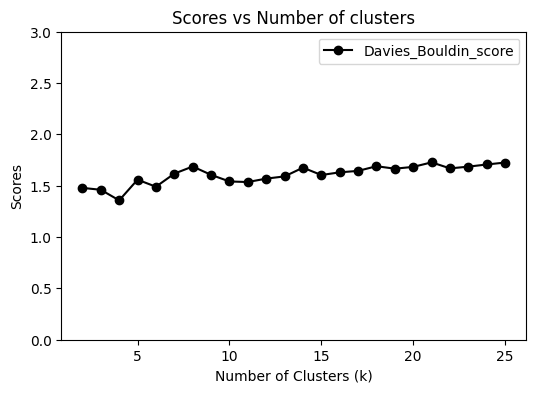

In [5]:
validation(train_data)

# K-means Clustering
change n_clusters as required

In [29]:
n_clusters = 6  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

2.951 --> 2.034 --> 1.920 --> 1.887 --> 1.880 --> 1.879 --> 1.876 --> 1.873 --> 1.867 --> 1.862 --> 1.855 --> 1.847 --> 1.839 --> 1.832 --> 1.825 --> 1.821 --> 1.819 --> 1.817 --> 1.816 --> 1.815 --> 1.815 --> 1.815 --> 1.814 --> 1.814 --> 1.814 --> 1.814 --> 1.814 --> 1.813 --> 1.813 --> 1.813 --> 1.813 --> 1.813 --> 


# Plotting the cluster average patterns

In [30]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season(save):
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title("daily_profiles, normalized for each household separately", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

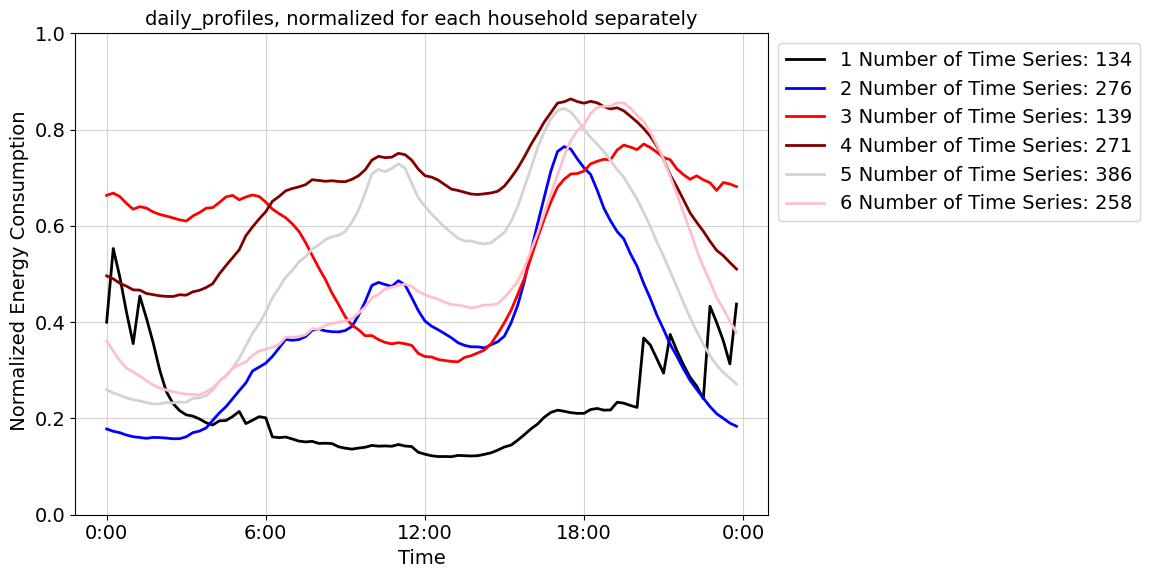

In [31]:
to_save = 0 #if you want to save the plots save=1

plot_clusters_season(to_save)

plt.rcParams['font.size'] = 14

## Actual energy consumption of each cluster

In [34]:
# total number of households per cluster, total energy consumption per cluster, averga eenergy consumption per cluster daily and anually

# Convert filename_list items to strings if not already
house_ids = [str(h) for h in filename_list]

# Create Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1  # adjust if needed
})

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/KMeans_Clustering/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]"),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]")
]).sort("cluster")

print(cluster_summary)



shape: (6, 4)
┌─────────┬────────────────┬─────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_total_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                         ┆ ---                         │
│ i64     ┆ u32            ┆ f64                         ┆ f64                         │
╞═════════╪════════════════╪═════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 134            ┆ 6665.476933                 ┆ 11.565947                   │
│ 2       ┆ 276            ┆ 2559.532377                 ┆ 4.496793                    │
│ 3       ┆ 139            ┆ 8427.422583                 ┆ 12.974649                   │
│ 4       ┆ 271            ┆ 5573.999712                 ┆ 9.85804                     │
│ 5       ┆ 386            ┆ 3416.50699                  ┆ 5.781344                    │
│ 6       ┆ 258            ┆ 3430.285802                 ┆ 5.766362                    │
└──────

### Plotting the clusters in separate plots

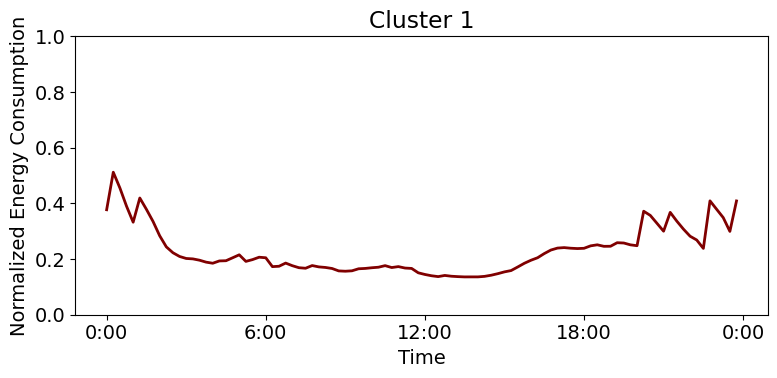

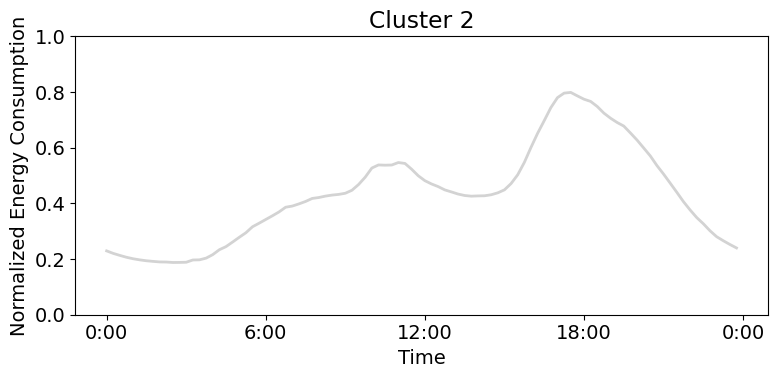

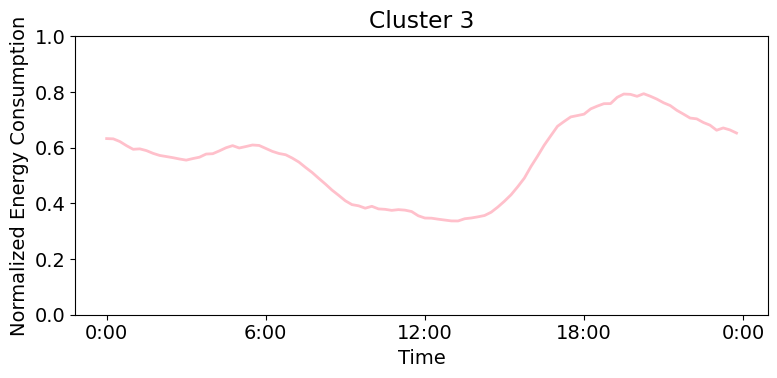

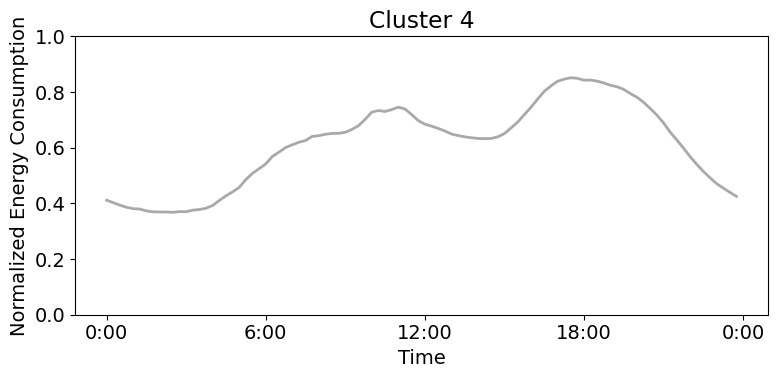

In [9]:
# Calculate and plot the average pattern for each cluster
save = 0 #if you want to save the plots

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','darkslategrey','turquoise','magenta','pink','violet']

for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    plt.figure(figsize=(8, 4))
    
    plt.plot(range(1,97), mean_time_series.ravel()[:96], 
             label= f'Mean Time Series \n No. of Time Series: {len(cluster_indices)}',
               linewidth =2, color= colors[cluster_idx] )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0,1)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()


### Plotting Mean, Median and percentiles of the clusters

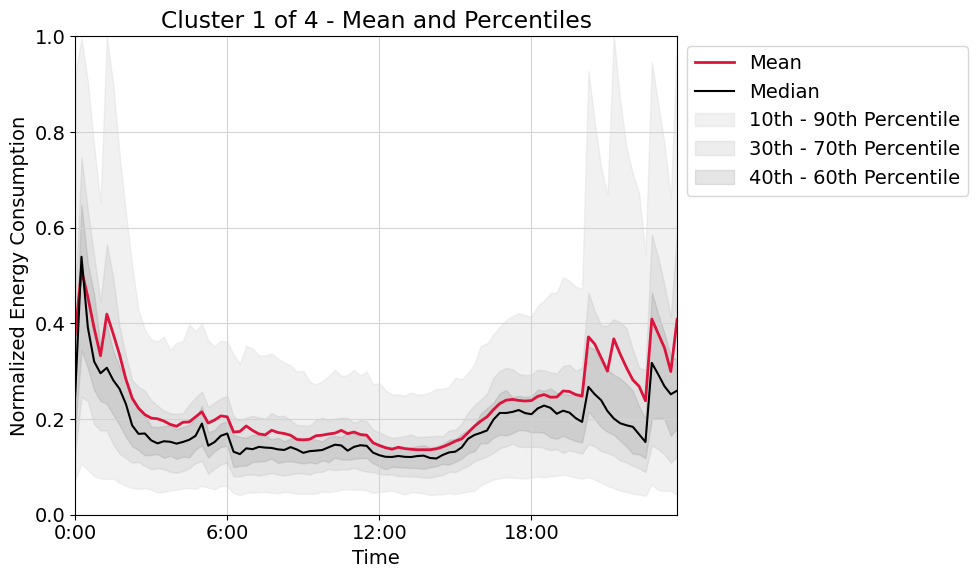

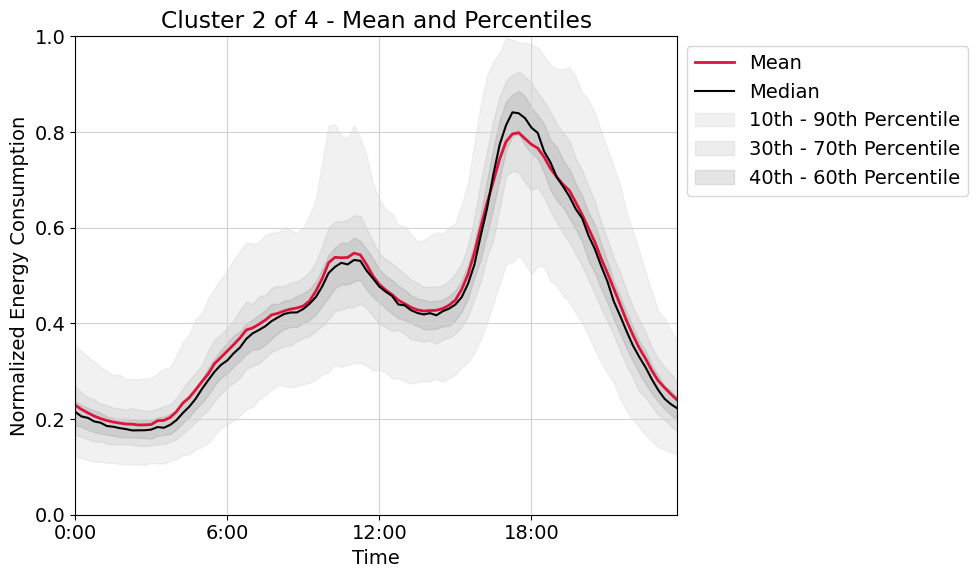

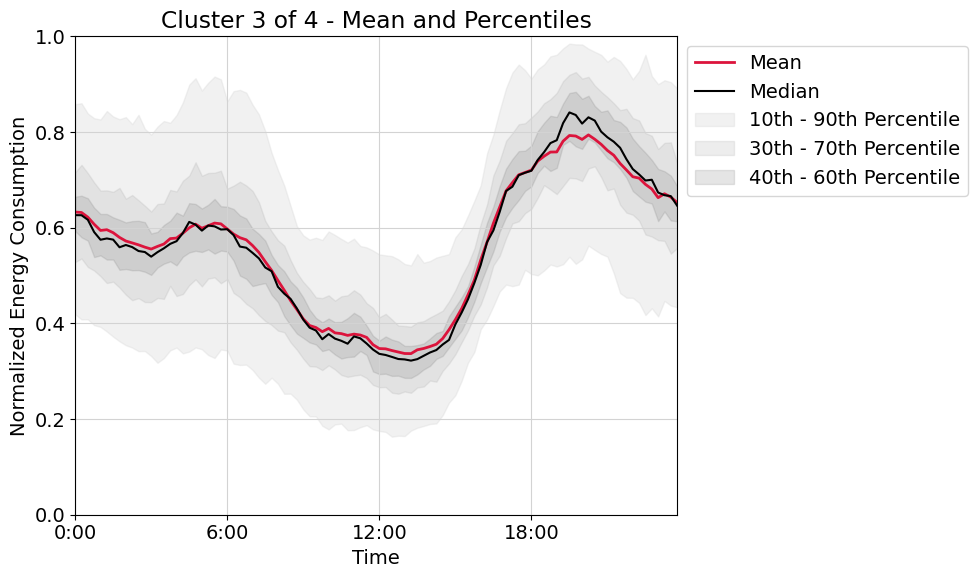

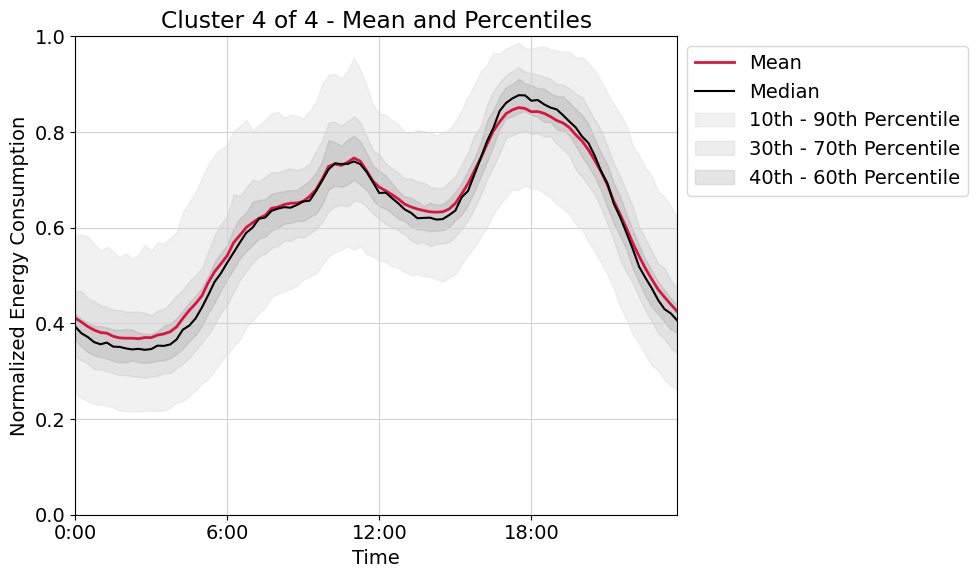

shape: (96, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ lower_perc ┆ lower_perc ┆ lower_perc ┆ lower_per ┆ upper_per ┆ upper_per ┆ upper_per ┆ upper_per │
│ entile_clu ┆ entile_clu ┆ entile_clu ┆ centile_c ┆ centile_c ┆ centile_c ┆ centile_c ┆ centile_c │
│ ster_1     ┆ ster_2     ┆ ster_3     ┆ luster_4  ┆ luster_1  ┆ luster_2  ┆ luster_3  ┆ luster_4  │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆ f64        ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.073497   ┆ 0.120844   ┆ 0.419038   ┆ 0.252951  ┆ 0.919099  ┆ 0.351152  ┆ 0.858064  ┆ 0.58463   │
│ 0.105854   ┆ 0.118409   ┆ 0.40834    ┆ 0.243624  ┆ 0.996009  ┆ 0.3419    ┆ 0.860108  ┆ 0.585341  │
│ 0.09378    ┆ 0.11443    ┆ 0.408597   ┆ 0.237176  ┆ 0.905798  ┆ 0.330701  ┆

In [10]:
plot_cluster_percentiles(train_data, clusters_train, n_clusters)